# 数据挖掘实践任务

<b>任务描述</b>

- 用逻辑回归、svm和决策树、随机森林和XGBoost进行模型构建，评分方式任意，如准确率等。（不需要考虑模型调参）

In [2]:
# 获取Task2进行特征选择后的数据集
import pandas as pd
dataset = pd.read_csv('./dataset/task2_proc.csv')
features = dataset.iloc[:,:-1]
labels = dataset.iloc[:,-1]
print('feature shape:{}, label shape:{}'.format(features.shape,labels.shape))

feature shape:(4455, 50), label shape:(4455,)


In [3]:
# 数据拆分
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

random_state = 2018
x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size = 0.3,random_state=random_state)

# 对训练数据集进行标准化处理
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.fit_transform(x_test)

In [4]:
# 导入库
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,cross_val_predict
from scipy.stats import uniform
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt

In [61]:
model_score_train = []   
decision_score_train = [] 
model_score_test = []   
decision_score_test = []

def proc_score(y_pred,y_pred_scores,y_test,train=True):  
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    roc_auc = roc_auc_score(y_test,y_pred_scores)

    if train:
        decision_score_train.append(y_pred_scores)
        model_score_train.append([accuracy,precision,recall,f1,roc_auc])
        text = 'Train'
    else:
        decision_score_test.append(y_pred_scores)
        model_score_test.append([accuracy,precision,recall,f1,roc_auc])
        text = 'Test'
 
    print('{}: accuracy:{:.3f},precision:{:.3f},recall:{:.3f},f1:{:.3f},roc_auc:{:.3f}'.format(text,accuracy,precision,recall,f1,roc_auc))

# 逻辑回归

In [6]:
param_distributions = {'C':uniform(0,10)}
rs_clf = RandomizedSearchCV(LogisticRegression(solver='liblinear'), param_distributions=param_distributions, cv = 3,n_iter=100,
                           random_state=random_state,verbose=2,n_jobs=-1)
rs_clf.fit(x_train_scale,y_train)
logistic = rs_clf.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.4s finished


In [62]:
y_pred = logistic.predict(x_train_scale)
y_pred_scores = cross_val_predict(logistic,x_train_scale,y_train,cv=5,
                                method='decision_function')
proc_score(y_pred,y_pred_scores,y_train,train=True)
y_pred = logistic.predict(x_test_scale)
y_pred_scores = cross_val_predict(logistic,x_test_scale,y_test,cv=5,
                                method='decision_function')
proc_score(y_pred,y_pred_scores,y_test,train=False)

Train: accuracy:0.799,precision:0.713,recall:0.355,f1:0.474,roc_auc:0.785
Test: accuracy:0.791,precision:0.624,recall:0.349,f1:0.448,roc_auc:0.784


# SVM

In [26]:
param_distributions = {'C':uniform(0,10)}
rs_clf = RandomizedSearchCV(SVC(kernel='linear'), param_distributions=param_distributions,cv=3,n_iter=100,
                              random_state=random_state,verbose=2,n_jobs=-1)
rs_clf.fit(x_train_scale, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='linear', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000220C5207860>},
                   pre_dispatch='2*n_jobs', random_state=2018, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [63]:
svc = rs_clf.best_estimator_

y_pred = svc.predict(x_train_scale)
y_pred_scores = cross_val_predict(svc,x_train_scale,y_train,cv=3,
                                method='decision_function')
proc_score(y_pred,y_pred_scores,y_train,train=True)

y_pred = svc.predict(x_test_scale)
y_pred_scores = cross_val_predict(svc,x_test_scale,y_test,cv=5,
                                method='decision_function')
proc_score(y_pred,y_pred_scores,y_test,train=False)

Train: accuracy:0.789,precision:0.779,recall:0.243,f1:0.371,roc_auc:0.784
Test: accuracy:0.791,precision:0.696,recall:0.241,f1:0.358,roc_auc:0.788


# 决策树

In [56]:
dt_clf = DecisionTreeClassifier(max_depth=8)
dt_clf.fit(x_train_scale,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [64]:
y_pred = dt_clf.predict(x_train_scale)
y_pred_scores = cross_val_predict(dt_clf,x_train_scale,y_train,cv=5,
                                method='predict_proba')
proc_score(y_pred,y_pred_scores[:,1],y_train,train=True)

y_pred = dt_clf.predict(x_test_scale)
y_pred_scores = cross_val_predict(dt_clf,x_test_scale,y_test,cv=5,
                                method='predict_proba')
proc_score(y_pred,y_pred_scores[:,1],y_test,train=False)

Train: accuracy:0.893,precision:0.883,recall:0.671,f1:0.763,roc_auc:0.642
Test: accuracy:0.746,precision:0.471,recall:0.383,f1:0.422,roc_auc:0.599


# 随机森林

In [58]:
rf_clf = RandomForestClassifier(n_estimators=1000,criterion='gini',oob_score=True,
                               random_state=random_state,verbose=0,n_jobs=-1)
rf_clf.fit(x_train_scale,y_train)
rf_clf.oob_score_

0.7957023733162284

In [65]:
y_pred = rf_clf.predict(x_train_scale)
y_pred_scores = cross_val_predict(rf_clf,x_train_scale,y_train,cv=5,
                                method='predict_proba')
proc_score(y_pred,y_pred_scores[:,1],y_train,train=True)

y_pred = rf_clf.predict(x_test_scale)
y_pred_scores = cross_val_predict(rf_clf,x_test_scale,y_test,cv=5,
                                method='predict_proba')
proc_score(y_pred,y_pred_scores[:,1],y_test,train=False)

Train: accuracy:1.000,precision:1.000,recall:1.000,f1:1.000,roc_auc:0.784
Test: accuracy:0.802,precision:0.712,recall:0.306,f1:0.428,roc_auc:0.777


# xgboost

In [32]:
from xgboost import XGBClassifier
xgbst = XGBClassifier()
xgbst.fit(x_train_scale,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [66]:
y_pred = xgbst.predict(x_train_scale)
y_pred_scores = cross_val_predict(xgbst,x_train_scale,y_train,cv=5,
                                method='predict_proba')
proc_score(y_pred,y_pred_scores[:,1],y_train,train=True)

y_pred = xgbst.predict(x_test_scale)
y_pred_scores = cross_val_predict(xgbst,x_test_scale,y_test,cv=5,
                                method='predict_proba')
proc_score(y_pred,y_pred_scores[:,1],y_test,train=False)

Train: accuracy:0.846,precision:0.843,recall:0.491,f1:0.620,roc_auc:0.783
Test: accuracy:0.806,precision:0.707,recall:0.343,f1:0.462,roc_auc:0.798


# 对各模型分数进行比较

In [67]:
model_name = ['Logistic','SVM','DecisionTree','RandomForest','xgboost']
columns = ['accuracy','precision','recall','f1','roc_auc']
ttype = ['train','test']
pd_list = []
for train,test in zip(model_score_train,model_score_test):
    pd_list.append(pd.DataFrame([train,test],index=ttype,columns=columns))
    
pd.concat(pd_list,axis=0,keys=model_name)

accuracy  precision    recall        f1   roc_auc
Logistic     train  0.798589   0.712846  0.355082  0.474037  0.785294
             test   0.791324   0.624309  0.348765  0.447525  0.784030
SVM          train  0.788967   0.779116  0.243413  0.370937  0.783726
             test   0.790576   0.696429  0.240741  0.357798  0.787960
DecisionTree train  0.893201   0.882838  0.671267  0.762651  0.642370
             test   0.746447   0.471483  0.382716  0.422487  0.599116
RandomForest train  1.000000   1.000000  1.000000  1.000000  0.783887
             test   0.801795   0.712230  0.305556  0.427646  0.776765
xgboost      train  0.846376   0.842672  0.490590  0.620143  0.783353
             test   0.806283   0.707006  0.342593  0.461538  0.798277

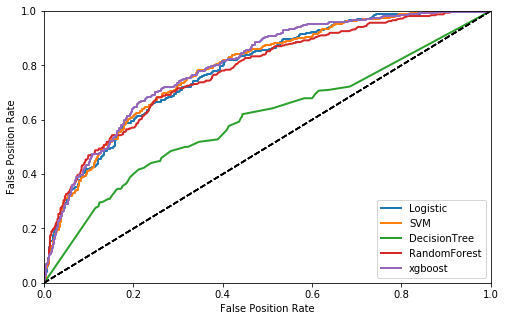

In [69]:
# 绘制ROC取下对比图
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')

for score,label in zip(decision_score_test,['Logistic','SVM','DecisionTree','RandomForest','xgboost']):
    fpr,tpr,threshold = roc_curve(y_test,score)
    plot_roc_curve(fpr,tpr,label)
plt.rcParams['figure.figsize'] = (8,5)    
plt.axis([0,1,0,1])
plt.xlabel('False Position Rate')
plt.ylabel('False Position Rate')
plt.legend()
plt.show()